In [3]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from sklearn.linear_model import LinearRegression

In [245]:
df_train = pd.read_pickle("df_train.pkl")
df_validation = pd.read_pickle("df_validation.pkl")
df_test = pd.read_pickle("df_test.pkl")
df_price = pd.read_pickle("df_price.pkl")
df_option = pd.read_pickle("df_merged.pkl")

In [90]:
from sklearn.linear_model import LinearRegression

In [772]:
def print_df(df):
    for idx, row in df.iterrows():
        print(", ".join([f"{col}={row[col]}" for col in df.columns]))

# **STATISTICAL STRATEGY : exploratory analysis**

As a first step, we use a manual and heuristic statistical approach to study and predict volatility. Instead of using complex mathematical models or machine learning, we build and test alphas based on simple observations, statistical patterns, and market intuition. The core idea is to leverage well-known features of volatility such as clustering, mean reversion, term structure, the gap between implied and realized volatility, and cross-reactions between IV and RV and translate them into tradable signals.

**Advantages**:
- Allows quick exploration of potential behaviors without complex models.
- Builds an initial understanding and intuition of IV vs RV dynamics.
- Strategies are easy to interpret, reproduce, and explain.

**Drawbacks**:
- Can quickly become obsolete, fragile, and unable to capture complex dynamics.
- Limited generalization power.
- Markets often behave counter-intuitively: simple rules like “if volatility goes up, it will keep going up” can be misleading. The most robust signals are sometimes the ones that seem the most counter-intuitive.

### **1st strategy**:

For a given quoted straddle, we look at the absolute log-returns of the last 3 days and the average IV (all maturities) over the same period. 
The strategy that performed best on df_train is the following:

- **LONG signal:**  
  If |log-return| is increasing and IV is also increasing → **LONG**

- **SHORT signal:**  
  If |log-return| is decreasing and IV is also decreasing →  **SHORT**.

In [680]:
def is_sorted(lst):
    return all(lst[i] <= lst[i+1] for i in range(len(lst)-1))

def is_sorted_desc(lst):
    return all(lst[i] >= lst[i+1] for i in range(len(lst)-1))

In [604]:
d1 = {}
d2 = {}
for d in df_train[df_train['Date'] > " 2016-03-01"]['Date'].unique():
    id_date = df_price['Date'].tolist().index(d)
    d1[d] = df_price['Price'].iloc[id_date - 3:id_date+1]
    id_date = df_train.groupby('Date')['IV'].mean().index.tolist().index(d)
    d2[d] = df_train.groupby('Date')['IV'].mean()[id_date - 2:id_date+1]

for d in d1.keys():
    d1[d] = np.abs(np.log(d1[d]/d1[d].shift(1)).dropna())


trade_valid = []
df_fil = df_train[df_train['Date'] > " 2016-03-01"].copy()
for _,row in df_fil.iterrows():
    d = row['Date']
    if (is_sorted(d1[d].tolist())) and (is_sorted(d2[d].tolist())): # LONG 
        trade_valid.append(row['vol_real'] > row['IV'])
    elif (is_sorted_desc(d1[d].tolist())) and (is_sorted_desc(d2[d].tolist())): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])

print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)} on df_train")

succes of 50.24875621890548% on 603 on df_train


In [605]:
d1 = {}
d2 = {}
for d in df_validation[df_validation['Date'] > " 2021-01-27"]['Date'].unique():
    id_date = df_price['Date'].tolist().index(d)
    d1[d] = df_price['Price'].iloc[id_date - 3:id_date+1]
    id_date = df_validation.groupby('Date')['IV'].mean().index.tolist().index(d)
    d2[d] = df_validation.groupby('Date')['IV'].mean()[id_date - 2:id_date+1]

for d in d1.keys():
    d1[d] = np.abs(np.log(d1[d]/d1[d].shift(1)).dropna())

trade_valid = []
df_fil = df_validation[df_validation['Date'] > " 2021-01-27"].copy()
for _,row in df_fil.iterrows():
    d = row['Date']
    if (is_sorted(d1[d].tolist())) and (is_sorted(d2[d].tolist())): # LONG 
        trade_valid.append(row['vol_real'] > row['IV'])
    elif (is_sorted_desc(d1[d].tolist())) and ( is_sorted_desc(d2[d].tolist())): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)} on df_validation")

succes of 55.46218487394958% on 119 on df_validation


### **2nd strategy**:

For a given quoted straddle, we will study the **term structure** dynamic (how maturity affects IV)

In [86]:
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        trade_valid = trade_valid + [list_rv[i] > list_iv[i] for i in range(len(df_date))]
print(f"There are {np.mean(trade_valid)*100}% RV>IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


There are 33.48623853211009% RV>IV (with 872 straddle) when the term structure is in ASCENDING order


In [89]:
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted_desc(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        trade_valid = trade_valid + [list_rv[i] < list_iv[i] for i in range(len(df_date))]
print(f"There are {np.mean(trade_valid)*100}% RV<IV (with {len(trade_valid)} straddle) when the term structure is in DESCENDING order")


There are 51.01123595505618% RV<IV (with 890 straddle) when the term structure is in DESCENDING order


Which is still lesser than the 62% of accuracy of SHORT postion in df_train...

Because of the structural bias favor short vol, we'll keep the short signal so we can generate positive PNL:

- **SHORT signal:**  
  If the term structure is increasing → **SHORT**

In [105]:
dic_slope = {}
trade_valid = []
df_filtered = df_train[df_train['Date'] > " 2016-03-01"][['Date','day_to_maturity','IV','vol_real']].copy()
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        list_iv = df_date['IV'].tolist()
        list_rv = df_date['vol_real'].tolist()
        Y = list_iv
        X = df_date['day_to_maturity'].tolist()

        X = np.array(X).reshape(-1, 1)
        Y = np.array(Y)

        model = LinearRegression()
        model.fit(X, Y)

        dic_slope[d] = model.coef_[0]
        #trade_valid = trade_valid + [list_rv[i] > list_iv[i] for i in range(len(df_date))]

#print(f"There are {np.mean(trade_valid)*100}% RV>IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


We now try to optimize the short signal. We perform linear regressions on periods with an increasing term structure to identify slope levels that correspond to a robust short signal.

The goal is to find a quantile threshold (threshold) so that the short signal is strong when the slope is above this quantile, among all slopes calculated on df_train.

In [118]:
threshold = 0
trade_valid = []
for d in df_filtered['Date'].unique().tolist():
    df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity', ascending=True)
    if is_sorted(df_date['IV'].tolist()):
        if dic_slope[d] > np.percentile(list(dic_slope.values()),threshold):
            list_iv = df_date['IV'].tolist()
            list_rv = df_date['vol_real'].tolist()
            trade_valid = trade_valid + [list_rv[i] < list_iv[i] for i in range(len(df_date))]

print(f"There are {np.mean(trade_valid)*100}% RV<IV (with {len(trade_valid)} straddle) when the term structure is in ASCENDING order")


There are 66.3594470046083% RV<IV (with 868 straddle) when the term structure is in ASCENDING order


Let's calibrate the theshold on df_train

In [ ]:
threshold_range = np.arange(0, 1.01, 0.01)  

best_threshold = None
best_rate = -np.inf

dates_unique = df_filtered['Date'].unique().tolist()
dic_slope_values = list(dic_slope.values())

for th in threshold_range:
    trade_valid = []
    for d in dates_unique:
        df_date = df_filtered[df_filtered['Date'] == d].sort_values(by='day_to_maturity')
        if is_sorted(df_date['IV'].tolist()):
            if dic_slope[d] > np.percentile(dic_slope_values, th*100):
                list_iv = df_date['IV'].tolist()
                list_rv = df_date['vol_real'].tolist()
                trade_valid.extend([list_rv[i] < list_iv[i] for i in range(len(df_date))])

    if trade_valid: 
        rate = np.mean(trade_valid)
        print(f"Threshold = {th:.2f}, success rate = {rate*100:.2f}% on {len(trade_valid)} straddles")
        if rate > best_rate:
            best_rate = rate
            best_threshold = th

print(f"\nBest threshold = {best_threshold:.2f} with success rate = {best_rate*100:.2f}%")

Threshold = 0.00, success rate = 66.36% on 868 straddles
Threshold = 0.01, success rate = 66.32% on 864 straddles
Threshold = 0.02, success rate = 66.20% on 855 straddles
Threshold = 0.03, success rate = 66.75% on 845 straddles
Threshold = 0.04, success rate = 66.95% on 835 straddles
Threshold = 0.05, success rate = 66.71% on 826 straddles
Threshold = 0.06, success rate = 66.55% on 822 straddles
Threshold = 0.07, success rate = 66.79% on 813 straddles
Threshold = 0.08, success rate = 66.92% on 804 straddles
Threshold = 0.09, success rate = 66.50% on 794 straddles
Threshold = 0.10, success rate = 66.50% on 785 straddles
Threshold = 0.11, success rate = 66.79% on 780 straddles
Threshold = 0.12, success rate = 66.45% on 772 straddles
Threshold = 0.13, success rate = 66.10% on 764 straddles
Threshold = 0.14, success rate = 66.31% on 754 straddles
Threshold = 0.15, success rate = 66.31% on 745 straddles
Threshold = 0.16, success rate = 66.08% on 740 straddles
Threshold = 0.17, success rate 

After calibration, the threshold seems to have little effect. We will therefore stick with the simple initial strategy.

Let's test the result on df_validation directly on `main.py`

## **3rd strategy**

**We will try a strategy based on the spread : historical_RV(day_to_mat) - IV(day_to_mat historical)**

In [607]:
df_filtered = pd.concat([df_train,df_validation], ignore_index = True)
df_filtered = df_filtered[df_filtered['Date'] > " 2016-03-01"]

In [608]:
def get_prices_list_historical(date, nb_period):
        ''' This function returns the list of spot prices for the nb_period preceding the date 
        provided as a parameter.

        RETURNS
        -------
        type : list
        '''
        list_date = df_price['Date'].tolist()
        id_date = list_date.index(date)
        filtered = df_price.iloc[id_date - nb_period : id_date + 1]
        return filtered['Price'].tolist()

def get_realized_volatility(prices):
    '''This function calculates the annualized realized volatility for a 
    given list of stock prices provided as the parameter prices.

    RETURNS
    -------
    type : float
    '''
    log_returns = np.diff(np.log(prices))
    realized_vol = np.sqrt(np.mean(log_returns ** 2) * 252)
    return realized_vol

In [609]:
get_realized_volatility(get_prices_list_historical(" 2016-03-02", 30))

0.3506556812075462

In [610]:
df_filtered = df_train[df_train['Date'] > " 2016-03-01"]

In [611]:
spread_realized1 = [] # among positive historical spread (rv - iv)
spread_realized2 = [] # among negative historical spread (rv - iv)
for _,row in df_filtered.iterrows():
    if get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) > row['IV']:
        spread_realized1.append(row['vol_real'] - row['IV'])
    elif get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) < row['IV']:
        spread_realized2.append(row['vol_real'] - row['IV'])


Statistics on RV - IV when RV_historical(day_to_mat) - IV **>** 0

In [612]:
pd.Series(spread_realized1).describe()

count    2501.000000
mean        0.004869
std         0.140148
min        -0.335740
25%        -0.060660
50%        -0.028390
75%         0.019330
max         0.790100
dtype: float64

Statistics on RV - IV when RV_historical(day_to_mat) - IV **<** 0

In [613]:
pd.Series(spread_realized2).describe()

count    3462.000000
mean       -0.001687
std         0.086539
min        -0.249800
25%        -0.052853
50%        -0.011175
75%         0.032195
max         0.723810
dtype: float64

In [ ]:
spread = [] # historical_RV(past days) - IV
spread_realized = [] # real futur RV - IV
for _,row in df_filtered.iterrows():
    spread.append(get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'])
    spread_realized.append(row['vol_real'] - row['IV'])

In [615]:
pd.Series(spread).describe()

count    5963.000000
mean       -0.003894
std         0.101483
min        -0.373224
25%        -0.068030
50%        -0.018435
75%         0.048472
max         0.570276
dtype: float64

In [616]:
spread_positif = [i for i in spread if i>0]
spread_negatif = [i for i in spread if i<0]

print(pd.Series(spread_positif).describe())
print(pd.Series(spread_negatif).describe())


count    2501.000000
mean        0.085594
std         0.085768
min         0.000166
25%         0.029263
50%         0.063575
75%         0.109653
max         0.570276
dtype: float64
count    3462.000000
mean       -0.068540
std         0.049601
min        -0.373224
25%        -0.094248
50%        -0.059825
75%        -0.031393
max        -0.000042
dtype: float64


In [617]:
spread_realized_positif = []
spread_realized_negatif = []
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV']
    if (spr in spread_positif) and (spr > np.percentile(spread_positif,90)):
        spread_realized_positif.append(row['vol_real'] - row['IV'])
    elif (spr in spread_negatif) and (spr < np.percentile(spread_negatif,10)):
        spread_realized_negatif.append(row['vol_real'] - row['IV'])

In [618]:
print(pd.Series(spread_realized_positif).describe()) # Statistic of realized volatility - IV when the spread of historical vol - IV > quantile(0.9) of all positive spread
print(pd.Series(spread_realized_negatif).describe()) # Statistic of realized volatility - IV when the spread of historical vol - IV < quantile(0.1) of all negative spread

count    250.000000
mean       0.001568
std        0.196037
min       -0.246990
25%       -0.106497
50%       -0.047645
75%        0.015195
max        0.790100
dtype: float64
count    347.000000
mean      -0.000978
std        0.087984
min       -0.249800
25%       -0.055890
50%        0.006880
75%        0.058775
max        0.265820
dtype: float64


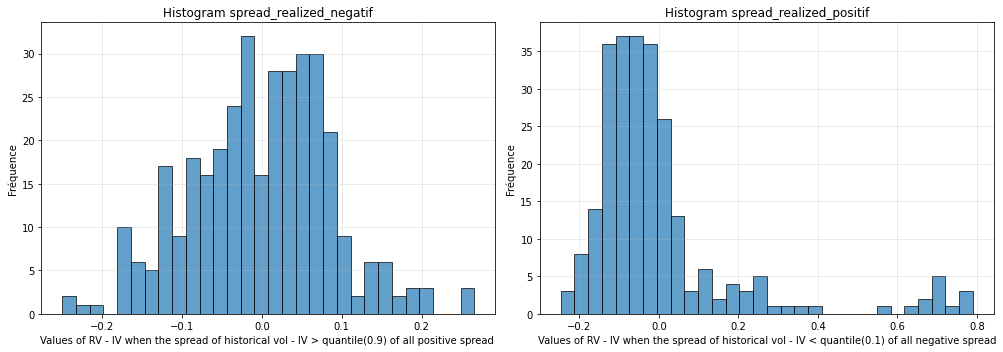

In [619]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].hist(spread_realized_negatif, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("Histogram spread_realized_negatif")
axes[0].set_xlabel("Values of RV - IV when the spread of historical vol - IV > quantile(0.9) of all positive spread ")
axes[0].set_ylabel("Fréquence")
axes[0].grid(alpha=0.3)

axes[1].hist(spread_realized_positif, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("Histogram spread_realized_positif")
axes[1].set_xlabel("Values of RV - IV when the spread of historical vol - IV < quantile(0.1) of all negative spread")
axes[1].set_ylabel("Fréquence")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [620]:
pd.Series(spread_realized_positif).mean()

0.0015681999999999975

In [621]:
pd.Series(spread_realized_negatif).mean()

-0.0009776945244956757

**OBSERVATION** : From the previous statistics, we observe that when historical volatility is significantly higher than implied volatility (i.e., when the spread RV – IV is above the 90th quantile among positive spreads), the option tends to be overpriced.
Conversely, when the spread RV – IV is below the 10th quantile among negative spreads (i.e., when IV is much larger than historical volatility), then IV tends to be underpriced.

### **Strategy**

- If (spread > quantile(spread_negatif,90%)) : **SHORT**
- If (spread < quantile(spread_negatif,10%)) : **LONG**

In [623]:
trade_valid=[]
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'] # spread 
    if (spr in spread_positif) and (spr > np.percentile(spread_positif,90)): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)} on SHORT")

succes of 68.8% on 250 on SHORT


In [624]:
trade_valid=[]
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'] # spread 
    if (spr in spread_negatif) and (spr < np.percentile(spread_negatif,10)): # LONG
        trade_valid.append(row['vol_real'] > row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)} on LONG")

succes of 52.1613832853026% on 347 on LONG


**OBSERVATION** : The result for LONG positions looks very promising, with 52% accuracy on df_train, which is much higher than random chance (38% on df_train).

In [55]:
trade_valid=[]
for _,row in df_filtered.iterrows():
    spr = get_realized_volatility(get_prices_list_historical(row['Date'],int(row['day_to_maturity']))) - row['IV'] # spread 
    if (spr in spread_positif) and (spr > np.percentile(spread_positif,90)): # SHORT
        trade_valid.append(row['vol_real'] < row['IV'])
    elif (spr in spread_negatif) and (spr < np.percentile(spread_negatif,10)): # LONG
        trade_valid.append(row['vol_real'] > row['IV'])
print(f"succes of {np.mean(trade_valid) * 100}% on {len(trade_valid)}")

succes of 59.12897822445561% on 597


We will now try to implement this strategy and backtest it directly in the main backtesting architecture and backtest it on `main.ipynb`

In [82]:
temp = 0
for d in df_train['Date'].unique():
    df_filt = df_train[df_train['Date'] == d]
    if not (all(df_filt['IV'] > df_filt['vol_real']) or all(df_filt['IV'] < df_filt['vol_real'])):
        temp+=1
print(f"there are {temp/len(df_train['Date'].unique()) * 100}% date where not all IV are > or < to RV")

there are 37.71532184950136% date where not all IV are > or < to RV


In [83]:
temp = 0
for d in df_validation['Date'].unique():
    df_filt = df_validation[df_validation['Date'] == d]
    if not (all(df_filt['IV'] > df_filt['vol_real']) or all(df_filt['IV'] < df_filt['vol_real'])):
        temp+=1
print(f"there are {temp/len(df_validation['Date'].unique()) * 100}% date where not all IV are > or < to RV")

there are 34.862385321100916% date where not all IV are > or < to RV


In [213]:
price_series = pd.Series(df_price['Price'].values, df_price['Date'])

In [439]:
price_series

Date
 2016-01-04     26.34
 2016-01-05     25.68
 2016-01-06     25.18
 2016-01-07     24.11
 2016-01-08     24.24
                ...  
 2025-07-28    214.05
 2025-07-29    211.27
 2025-07-30    209.05
 2025-07-31    207.57
 2025-08-01    202.38
Length: 2409, dtype: float64

In [455]:
price_series.index[2404]

' 2025-07-28'

In [454]:
price_series.index.get_loc(' 2025-07-28')

2404

In [458]:
price_series[2404-5:2405]

Date
 2025-07-21    212.48
 2025-07-22    214.40
 2025-07-23    214.15
 2025-07-24    213.76
 2025-07-25    213.88
 2025-07-28    214.05
dtype: float64

In [457]:
price_series.iloc[2404]

214.05

## **SKEW Analysis** ----------------------------------------------------------------------------------------------------

In this section, we will analyze option skew to build an alpha on (RV vs IV). The study will be divided into four distinct quantitative analyses:

- Risk reversal on delta 25

- Risk reversal at fixed moneyness (downside)

- Quadratic regression

- Principal Component Analysis (PCA)

The intuition behind this strategy is that skew is a good indicator of future volatility. In particular, the downside skew, or the implied volatility of OTM puts (often used as protection against crashes and volatility spikes), effectively reflects the market’s perception of extreme move risk.

### **4th Strategy** :

### Risk reversal on delta 25

**CONTEXT** : For each trading date, we will study the difference in implied volatility between the OTM put with **delta = -0.25** and the OTM call with **delta = 0.25**. This difference, called **risk_reversal_25**, is a good leading indicator of future volatility.

In [69]:
import plotly.graph_objects as go

In [ ]:
# df_option = pd.read_pickle("df_merged.pkl")

In [273]:
len(df_option)

1554718

In [274]:
df_option[' [C_IV]'] = pd.to_numeric(df_option[' [C_IV]'], errors='coerce')
df_option[' [P_IV]'] = pd.to_numeric(df_option[' [P_IV]'], errors='coerce')

df_option[' [C_DELTA]'] = pd.to_numeric(df_option[' [C_DELTA]'], errors='coerce')
df_option[' [P_DELTA]'] = pd.to_numeric(df_option[' [P_DELTA]'], errors='coerce')

df_option['IV'] = ((df_option[' [C_IV]'] + df_option[' [P_IV]']) / 2).round(5)
df_option = df_option.dropna(subset=['IV'])

df_filtered_option = df_option[['Date','day_to_maturity',' [C_IV]',' [C_DELTA]',' [P_IV]',' [P_DELTA]','IV','moneyness']].copy()

df_filtered_option = df_filtered_option[df_option['day_to_maturity'] <= 21]
df_filtered_option = df_filtered_option[df_option['day_to_maturity'] >= 12]

#df_filtered_option = df_filtered_option[df_option['moneyness'] >= 0.8]
#df_filtered_option = df_filtered_option[df_option['moneyness'] <= 1.1]

df_filtered_option['tau'] = df_filtered_option['day_to_maturity']/252
#df_filtered_option = df_filtered_option[df_filtered_option['tau'] < 0.12] # tau < 30 days


C:\Users\Jason\AppData\Local\Temp\ipykernel_2456\78195128.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [452]:
begin_date = ' 2016-03-02'
end_date_train = df_train['Date'].unique().tolist()[-1] # ' 2021-01-20'
end_date_validation = df_validation['Date'].unique().tolist()[-1] # ' 2021-12-22'

In [ ]:
list_date = df_filtered_option['Date'].unique().tolist() # ALL THE DIFFERENT DATE FROM df_filtered_option (NOT df_train + df_validation + df_test that had been filtered only with ATM)

In [353]:
id_begin_date = list_date.index(beging_date)
id_end_date_train = list_date.index(end_date_train)
id_end_date_validation = list_date.index(end_date_validation)

In [360]:
list_date_train = list_date[:id_end_date_train+1]
list_date_train_validation = list_date[:id_end_date_validation+1]

In [408]:
missing_dates = set(list_date_train) - set(df_train['Date'].unique())
print(missing_dates)

{' 2018-02-05', ' 2018-06-15', ' 2019-08-30', ' 2018-12-21', ' 2018-03-15', ' 2019-01-09', ' 2017-10-31', ' 2018-01-19', ' 2018-12-11', ' 2017-09-19', ' 2017-05-26', ' 2019-04-18', ' 2018-11-06', ' 2019-07-09', ' 2017-05-30', ' 2018-04-06', ' 2018-01-17', ' 2019-02-12', ' 2017-11-27', ' 2017-11-15', ' 2018-08-24', ' 2017-08-09', ' 2019-06-17', ' 2017-08-16', ' 2018-08-13', ' 2019-02-07', ' 2019-03-28', ' 2018-07-03', ' 2017-09-29', ' 2019-03-25', ' 2018-03-22', ' 2019-03-14', ' 2019-09-27', ' 2018-02-26', ' 2018-03-02', ' 2019-03-19', ' 2018-10-08', ' 2019-09-13', ' 2018-03-14', ' 2018-11-14', ' 2018-02-21', ' 2017-09-20', ' 2018-01-25', ' 2017-09-11', ' 2019-02-19', ' 2019-01-23', ' 2019-07-24', ' 2019-10-11', ' 2019-03-12', ' 2020-08-11', ' 2017-09-08', ' 2017-07-26', ' 2019-03-11', ' 2018-05-15', ' 2019-03-15', ' 2018-12-28', ' 2018-03-21', ' 2018-02-09', ' 2017-11-14', ' 2019-07-23', ' 2019-06-24', ' 2020-03-20', ' 2018-04-03', ' 2018-07-13', ' 2019-05-06', ' 2018-07-12', ' 2017-10

In [ ]:
'''df_filtered = df_filtered_option[df_filtered_option['Date'] == list_date[10]]
df_filtered = df_filtered.sort_values(by=' [C_DELTA]')
print(len(df_filtered))
print(df_filtered['day_to_maturity'].unique())'''

In [ ]:
'''for idx, row in df_filtered.iterrows():
    print(", ".join([f"{col}={row[col]}" for col in df_filtered.columns]))'''

In [588]:
historical_rr25 = []
for d in list_date:
    # print(d)
    df_filtered = df_filtered_option[df_filtered_option['Date'] == d]
    idx_c = (df_filtered[' [C_DELTA]'] - 0.25).abs().idxmin()
    idx_p = (df_filtered[' [P_DELTA]'] + 0.25).abs().idxmin()
    historical_rr25.append(df_filtered.loc[idx_p][' [P_IV]'] - df_filtered.loc[idx_c][' [C_IV]'])

In [591]:
historical_rr25 = pd.Series(historical_rr25,list_date)

In [589]:
historical_rr25_train = []
for d in list_date_train:
    # print(d)
    df_filtered = df_filtered_option[df_filtered_option['Date'] == d]
    idx_c = (df_filtered[' [C_DELTA]'] - 0.25).abs().idxmin()
    idx_p = (df_filtered[' [P_DELTA]'] + 0.25).abs().idxmin()
    historical_rr25_train.append(df_filtered.loc[idx_p][' [P_IV]'] - df_filtered.loc[idx_c][' [C_IV]'])
    

In [590]:
historical_rr25_train = pd.Series(historical_rr25_train,list_date_train)

In [433]:
historical_rr25_train_filtered = historical_rr25_train.drop(missing_dates, errors = 'ignore')

In [434]:
historical_date = pd.to_datetime(historical_rr25_train_filtered.index.tolist())

In [411]:
rv_train = [df_train[df_train['Date'] == d].groupby('Date')['vol_real'].mean()[0] for d in df_train['Date'].unique().tolist()]
iv_train = [df_train[df_train['Date'] == d].groupby('Date')['IV'].mean()[0] for d in df_train['Date'].unique().tolist()]

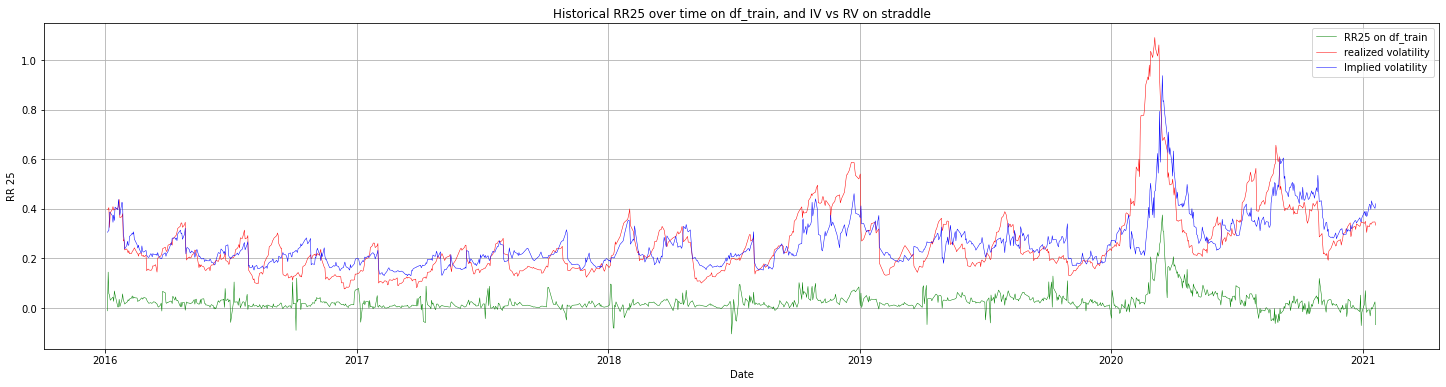

In [625]:
plt.figure(figsize=(25,6))

plt.plot(historical_date, historical_rr25_train_filtered.tolist(), label='RR25 on df_train', color='green', linewidth=0.5)
plt.plot(historical_date, rv_train, label='realized volatility', color='red', linewidth=0.5)
plt.plot(historical_date, iv_train, label='Implied volatility', color='blue', linewidth=0.5)
plt.xlabel("Date")
plt.ylabel("RR 25")
plt.title("Historical RR25 over time on df_train, and IV vs RV on straddle")
plt.legend()
plt.grid(True)

**REMARK** : From this chart, we can see that RR25 seems to capture future increases and decreases in volatility quite well. This is promising, since this information is already known at the time the straddle is quoted.

In [ ]:
# Get the 10 last rr25
dict_rr25 = {}
df_train_filtered = df_train[df_train['Date'] >= begin_date]
for d in df_train_filtered['Date'].unique():
    id_date = historical_rr25_train.index.get_loc(d)
    dict_rr25[d] = historical_rr25_train[id_date-9:id_date+1]

In [744]:
begin_date

' 2016-03-02'

In [489]:
iv_train = pd.Series(iv_train, df_train['Date'].unique())

In [ ]:
# get the 10 last IV
dict_iv = {}
for d in df_train_filtered['Date'].unique():
    id_date = iv_train.index.get_loc(d)
    dict_iv[d] = iv_train[id_date-9:id_date+1]

Let's try this strategy : 

- **LONG signal:**  
  If (rr25 - moyenne historique rv > threshold) AND (3 last IV days descending) → **LONG**

- **SHORT signal:**  
  If (3 last rr25 decrease) AND (rr25 - last rr25 < threshold)  → **SHORT**

CALIBRATION OF THE STRATEGY : LONG

In [776]:
threshold_range = np.arange(0, 0.03, 0.001)
# CONDITION LONG : (rr25 - moyenne historique rv > threshold) AND (3 last IV days descending) 
dates = df_train_filtered['Date'].values
vol_real = df_train_filtered['vol_real'].values
iv = df_train_filtered['IV'].values


mean_rr25 = {d: np.mean(dict_rr25[d][-4:-1]) for d in set(dates)}

for t in threshold_range:
    trade_valid = []
    for i in range(len(dates)):
        d = dates[i]
        if (historical_rr25.loc[d] - mean_rr25[d] > t) and is_sorted_desc(dict_iv[d][-3:]):
            trade_valid.append(vol_real[i] > iv[i])
    print(f"succes of {np.mean(trade_valid) * 100:.2f}% on {len(trade_valid)} with threshold = {t}")

succes of 37.87% on 581 with threshold = 0.0
succes of 39.31% on 524 with threshold = 0.001
succes of 41.46% on 451 with threshold = 0.002
succes of 43.07% on 397 with threshold = 0.003
succes of 44.38% on 356 with threshold = 0.004
succes of 47.13% on 314 with threshold = 0.005
succes of 46.71% on 289 with threshold = 0.006
succes of 49.06% on 267 with threshold = 0.007
succes of 48.96% on 241 with threshold = 0.008
succes of 46.72% on 229 with threshold = 0.009000000000000001
succes of 50.00% on 210 with threshold = 0.01
succes of 49.46% on 184 with threshold = 0.011
succes of 51.72% on 174 with threshold = 0.012
succes of 49.07% on 161 with threshold = 0.013000000000000001
succes of 51.97% on 152 with threshold = 0.014
succes of 52.67% on 131 with threshold = 0.015
succes of 50.79% on 126 with threshold = 0.016
succes of 52.83% on 106 with threshold = 0.017
succes of 52.83% on 106 with threshold = 0.018000000000000002
succes of 62.22% on 90 with threshold = 0.019
succes of 60.27% on

Let's retain the threshold of 0.015 that have performed 52.67% of accuracy on LONG over 131 traded which is better than 38% 

THRESHOLD SHORT CALIBRATION

In [775]:
#threshold_range = np.arange(-0.05, 0.01, 0.001)
threshold_range = np.arange(-0.02, 0, 0.001)
# CONDITION SHORT : (3 last rr25 decrease) AND (rr25 - last rr25 > threshold) 
dates = df_train_filtered['Date'].values
vol_real = df_train_filtered['vol_real'].values
iv = df_train_filtered['IV'].values


mean_rr25 = {d: np.mean(dict_rr25[d][-4:-1]) for d in set(dates)}

for t in threshold_range:
    trade_valid = []
    for i in range(len(dates)):
        d = dates[i]
        if is_sorted_desc(dict_rr25[d][-3:]) and (dict_rr25[d][-1] - dict_rr25[d][-2] > t):

            trade_valid.append(vol_real[i] < iv[i])
    print(f"succes of {np.mean(trade_valid) * 100:.2f}% on {len(trade_valid)} with threshold = {t}")

succes of 64.95% on 1050 with threshold = -0.02
succes of 64.82% on 1046 with threshold = -0.019
succes of 65.32% on 1038 with threshold = -0.018
succes of 64.67% on 1019 with threshold = -0.016999999999999998
succes of 64.81% on 986 with threshold = -0.015999999999999997
succes of 65.74% on 972 with threshold = -0.014999999999999996
succes of 65.86% on 952 with threshold = -0.013999999999999995
succes of 66.10% on 947 with threshold = -0.012999999999999994
succes of 66.41% on 917 with threshold = -0.011999999999999993
succes of 64.99% on 877 with threshold = -0.010999999999999992
succes of 65.42% on 827 with threshold = -0.009999999999999992
succes of 65.50% on 803 with threshold = -0.00899999999999999
succes of 65.85% on 779 with threshold = -0.00799999999999999
succes of 67.41% on 718 with threshold = -0.006999999999999989
succes of 68.96% on 625 with threshold = -0.005999999999999988
succes of 71.29% on 526 with threshold = -0.004999999999999987
succes of 71.34% on 471 with thresho

We will keep the threshold of -0.005, which achieved an accuracy of over 71.29% over 526 traded, clearly higher than the 62% baseline.

### **4th Strategy** :

### Risk reversal at fixed moneyness (downside)

---

In [430]:
'''# Préparer les données pour le graphe
date_fig = df_filtered['Date'].unique().tolist()[0]
X = df_filtered['moneyness']
Y = df_filtered['tau']
Z = df_filtered['IV']

# Créer le graphique 3D interactif
fig = go.Figure(data=[go.Scatter3d(
    x=X,
    y=Y,
    z=Z,
    mode='markers',
    marker=dict(
        size=5,
        color=Z,  # Colorier par la volatilité implicite
        colorscale='Viridis',  # Choisir une échelle de couleur
        colorbar=dict(title='Implied Volatility')  # Ajouter une barre de couleur
    )
)])

fig.update_traces(marker=dict(size=1))

# Ajouter des titres et labels
fig.update_layout(
    title=f'Volatility surface -- {date_fig}',
    scene=dict(
        xaxis_title='Moneyness K/S',
        yaxis_title='Maturity (day/252)',
        zaxis_title='Implied Volatility'
    ),
    autosize=True,
    width=1200,  # Largeur de la fenêtre en pixels
    height=800
)

# Afficher le graphique interactif
fig.show()'''

"# Préparer les données pour le graphe\ndate_fig = df_filtered['Date'].unique().tolist()[0]\nX = df_filtered['moneyness']\nY = df_filtered['tau']\nZ = df_filtered['IV']\n\n# Créer le graphique 3D interactif\nfig = go.Figure(data=[go.Scatter3d(\n    x=X,\n    y=Y,\n    z=Z,\n    mode='markers',\n    marker=dict(\n        size=5,\n        color=Z,  # Colorier par la volatilité implicite\n        colorscale='Viridis',  # Choisir une échelle de couleur\n        colorbar=dict(title='Implied Volatility')  # Ajouter une barre de couleur\n    )\n)])\n\nfig.update_traces(marker=dict(size=1))\n\n# Ajouter des titres et labels\nfig.update_layout(\n    title=f'Volatility surface -- {date_fig}',\n    scene=dict(\n        xaxis_title='Moneyness K/S',\n        yaxis_title='Maturity (day/252)',\n        zaxis_title='Implied Volatility'\n    ),\n    autosize=True,\n    width=1200,  # Largeur de la fenêtre en pixels\n    height=800\n)\n\n# Afficher le graphique interactif\nfig.show()"

In [ ]:
mask = (
    (df_merged['moneyness'] >= 0.995) & 
    (df_merged['moneyness'] <= 1.005) & 
    (df_merged['day_to_maturity'] <= 30) & 
    (df_merged['day_to_maturity'] > 5) 
)

---

---